In [ ]:
!gdown --id 10fKUF1u3uhIrhEipoklNgysmPyYuYGV9 -O kaggle_m3.zip
!gdown --id 1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ -O data_aug.zip

In [ ]:
! mkdir fakes
! cp data_aug.zip fakes
%cd fakes
! ls

/content/fakes
data_aug.zip


In [ ]:
! unzip data_aug.zip

In [ ]:
%cd ..

/content


In [ ]:
!unzip kaggle_m3.zip

# Import Dataset

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf

import os
import cv2
from PIL import Image
import numpy as np

In [ ]:
# Set parameters
file_path='/'
Size = (256, 256)
mask_files = glob(file_path + os.path.join('content','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]


def label(mask):
    value = np.max(cv2.imread(mask))
    return 1 if value > 0 else 0
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

df.shape

(5302, 3)

## Split data train (0.9) valid (0.05) test (0.05)

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)
df_test, df_val = train_test_split(df_test, test_size=0.5)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(4771, 3)
(266, 3)
(265, 3)


## Funcrion To augmentation and Scalling

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# Segmentation Model

In [ ]:
from keras import Input
from keras.layers import concatenate, UpSampling2D
from keras.models import Model

def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs= inputs, outputs = conv10)
    return model

In [ ]:
m=unet()

In [ ]:
from keras import backend as K
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
# Set parameters
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=Size)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=Size)

In [ ]:
model = unet(input_size=(Size[0], Size[1], 3))

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

callbacks = [ModelCheckpoint('brainMRI_Segment.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

In [ ]:
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Found 4771 validated image filenames.
Found 4771 validated image filenames.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


149/149 [==============================] - ETA: 0s - loss: 0.6828 - iou: 0.2747 - dice_coef: 0.4028Found 266 validated image filenames.
Found 266 validated image filenames.
149/149 [==============================] - 162s 1s/step - loss: 0.6828 - iou: 0.2747 - dice_coef: 0.4028 - val_loss: 0.3710 - val_iou: 0.5004 - val_dice_coef: 0.6656 - lr: 1.0000e-04
Epoch 2/100
149/149 [==============================] - 153s 1s/step - loss: 0.3995 - iou: 0.4862 - dice_coef: 0.6492 - val_loss: 0.3857 - val_iou: 0.4812 - val_dice_coef: 0.6428 - lr: 1.0000e-04
Epoch 3/100
149/149 [==============================] - 152s 1s/step - loss: 0.3311 - iou: 0.5516 - dice_coef: 0.7055 - val_loss: 0.4545 - val_iou: 0.4238 - val_dice_coef: 0.5940 - lr: 1.0000e-04
Epoch 4/100
149/149 [==============================] - 153s 1s/step - loss: 0.2978 - iou: 0.5871 - dice_coef: 0.7369 - val_loss: 0.2720 - val_iou: 0.6026 - val_dice_coef: 0.7498 - lr: 1.0000e-04
Epoch 5/100
149/149 [==============================] - 153s

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=Size)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 265 validated image filenames.
Found 265 validated image filenames.
8/8 [==============================] - 4s 458ms/step - loss: 0.1384 - iou: 0.7868 - dice_coef: 0.8804
Test IOU:  0.7868484854698181
Test Dice Coefficent:  0.8803805112838745


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
! pwd

/content


In [ ]:
%cd ..

/


In [ ]:
model.save('brainMRI_Segment.h5')

In [ ]:
df_test

,image,mask,label
2295,/content/TCGA_HT_7475_19970918/TCGA_HT_7475_19...,/content/TCGA_HT_7475_19970918/TCGA_HT_7475_19...,1
3690,/content/fakes/aug_TCGA_DU_7008_19830723_30.tif,/content/fakes/aug_TCGA_DU_7008_19830723_30_ma...,1
1675,/content/TCGA_HT_7686_19950629/TCGA_HT_7686_19...,/content/TCGA_HT_7686_19950629/TCGA_HT_7686_19...,1
1475,/content/TCGA_DU_5853_19950823/TCGA_DU_5853_19...,/content/TCGA_DU_5853_19950823/TCGA_DU_5853_19...,1
1613,/content/TCGA_DU_7298_19910324/TCGA_DU_7298_19...,/content/TCGA_DU_7298_19910324/TCGA_DU_7298_19...,0
...,...,...,...
4366,/content/fakes/aug_TCGA_HT_7475_19970918_27.tif,/content/fakes/aug_TCGA_HT_7475_19970918_27_ma...,1
2236,/content/TCGA_DU_6405_19851005/TCGA_DU_6405_19...,/content/TCGA_DU_6405_19851005/TCGA_DU_6405_19...,0
1688,/content/TCGA_HT_7686_19950629/TCGA_HT_7686_19...,/content/TCGA_HT_7686_19950629/TCGA_HT_7686_19...,0
4761,/content/fakes/aug_TCGA_HT_7881_19981015_23.tif,/content/fakes/aug_TCGA_HT_7881_19981015_23_ma...,1


In [ ]:
def get_random_image(df, col_name="image"):
    index=np.random.randint(1,len(df.index))
    img = cv2.imread(df[col_name].iloc[index])
    img = cv2.resize(img ,Size)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    return img

In [ ]:
test_img = get_random_image(df_test[df_test["label"] == 1])
test_img.shape

(1, 256, 256, 3)

In [ ]:
np.squeeze(test_img).shape

(256, 256, 3)

In [ ]:
pred_img = model.predict(test_img)

In [ ]:
pred_img.shape

(1, 256, 256, 1)

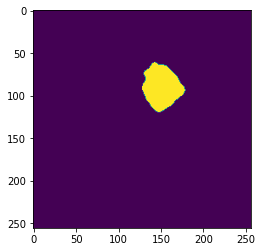

In [ ]:
plt.imshow(np.squeeze(pred_img) > .5)

(array([6.3512e+04, 3.2000e+01, 1.2000e+01, 1.8000e+01, 2.2000e+01,
        1.5000e+01, 1.3000e+01, 2.0000e+01, 2.8000e+01, 1.8640e+03]),
 array([0.        , 0.09999986, 0.19999972, 0.29999956, 0.39999944,
        0.49999928, 0.5999991 , 0.699999  , 0.7999989 , 0.8999987 ,
        0.99999857], dtype=float32),
 <a list of 10 Patch objects>)

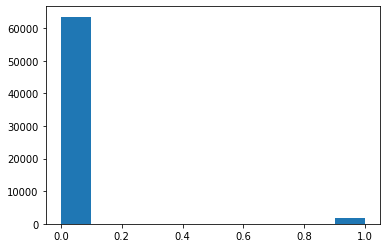

In [ ]:
plt.hist(pred_img.reshape(-1))

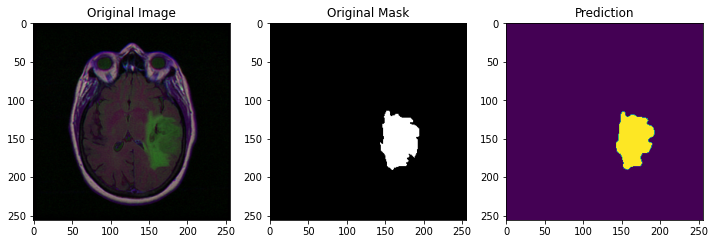

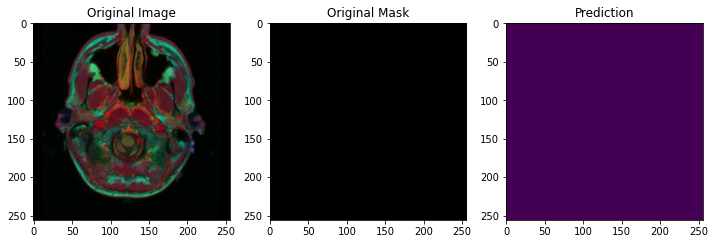

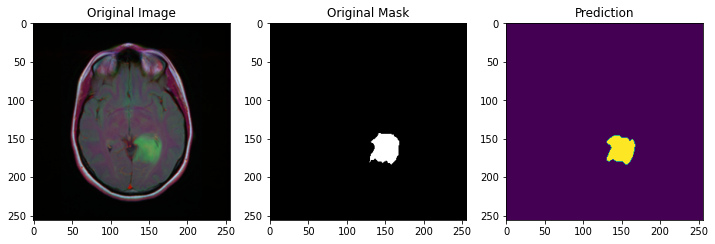

In [ ]:
for i in range(3):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image'].iloc[index])
    img = cv2.resize(img ,Size)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
My_X_test = [ cv2.imread(path) for path in df_test["image"]  ]
My_y_test = df_test["label"].values

My_X_test = np.array(My_X_test) / 255.0

print(My_X_test.shape)
print(My_y_test.shape)

(265, 256, 256, 3)
(265,)


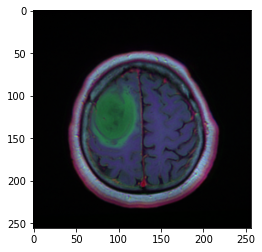

In [ ]:
plt.imshow(My_X_test[0])

In [ ]:
class MyModel:
  def __init__(self, model) -> None:
      self.model = model

  def predict(self, images):
      final_pred = []
      y_pred = self.model.predict(images)
      for idx in range(y_pred.shape[0]):
        pred_mask = y_pred[idx]
        result = 1 if np.max(pred_mask.reshape(-1)) > 0.1 else 0
        final_pred.append(result)
      
      return np.array(final_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matraix(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict(X_test)
    # y_pred = np.where(np.max(y_pred.reshape(-1)) >= threshold, 1, 0)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, range(2),range(2))
    plt.figure(figsize = (10,10))
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    s = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
    s.set(xlabel='Predicted Label', ylabel='True Label')

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       119
           1       0.88      0.95      0.91       146

    accuracy                           0.90       265
   macro avg       0.91      0.90      0.90       265
weighted avg       0.90      0.90      0.90       265



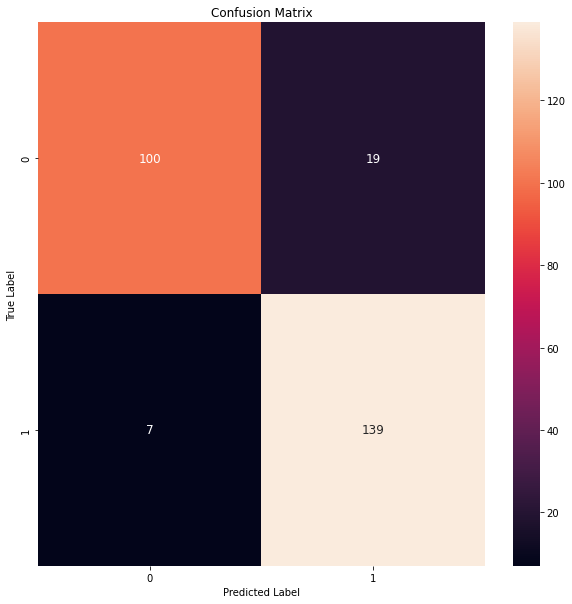

In [ ]:
my_model = MyModel(model)

plot_confusion_matraix(my_model, My_X_test, My_y_test)